In [1]:
import numpy as np
import swift_scrape
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import math
import pandas as pd
from lc_lmfit import *

In [2]:
folder='afterglow_data/'
filename='_xray_flux.txt'
GRBs=["050724","060614","070714B","150424A","211211A","211227A","061210","071227"]

### Extracting and Plotting Curves


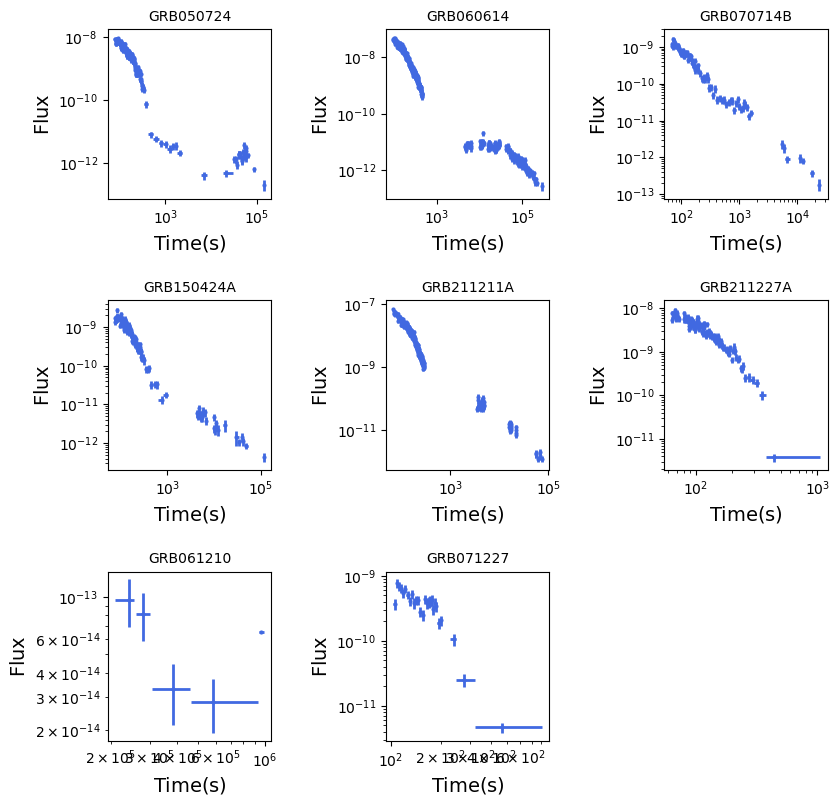

In [41]:
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.7)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(3, 3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### GRB i=5

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 113
    # data points      = 30
    # variables        = 2
    chi-square         = 44.1314280
    reduced chi-square = 1.57612243
    Akaike info crit   = 15.5792440
    Bayesian info crit = 18.3816387
[[Variables]]
    alpha_1:    5.42595525 +/- 0.28639002 (5.28%) (init = 3.2)
    amplitude:  1746.23742 +/- 2627.12910 (150.45%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = +0.9982


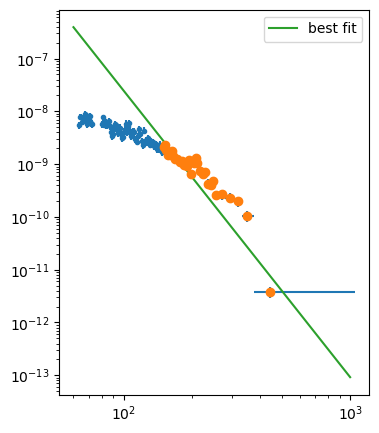

In [4]:
i=5
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 70
params=lm.Parameters()
# params.add("t_break", min = 100, max = 300, value = 173, vary=False)
# params.add("alpha_2", min = 3.0, max = 9.0, value = 6, vary=False)
params.add("alpha_1", min = 0, max = 10, value = 3.2)
params.add("amplitude", min = 1e-3, max = 1e4, value = 1e-2)

minner = lm.Minimizer(cost_func_pl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="least_squares")

bfit = result.params
# tb = bfit["t_break"].value
# alp2 = bfit["alpha_2"].value
alp1 = bfit["alpha_1"].value
amp = bfit["amplitude"].value

lm.printfuncs.report_fit(result)

x1=np.linspace(60,1e3,30)
fig=plt.figure(figsize=(4.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.errorbar(time[fit_index:], flux[fit_index:], fmt='o')
# plt.plot(x1,power_law(x1, 3.2, 1.5e-2),label ='best fit')
plt.plot(x1,power_law(x1,alp1,amp),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [76]:
res_refined = lm.minimize(cost_func_pl, method='emcee', burn=1000, steps=50000,
                            params=bfit, is_weighted=True, args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]),
                            nwalkers = 100)


100%|██████████| 50000/50000 [01:33<00:00, 537.62it/s]


{'alpha_1': 5.5770093360172375, 'amplitude': 3826.6014384430982}

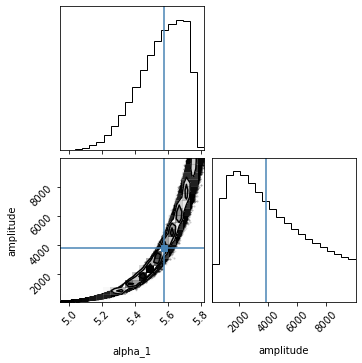

In [77]:
emcee_plot = corner.corner(res_refined.flatchain, labels=res_refined.var_names,
                           truths=list((res_refined.params.valuesdict().values())))

res_refined.params.valuesdict()

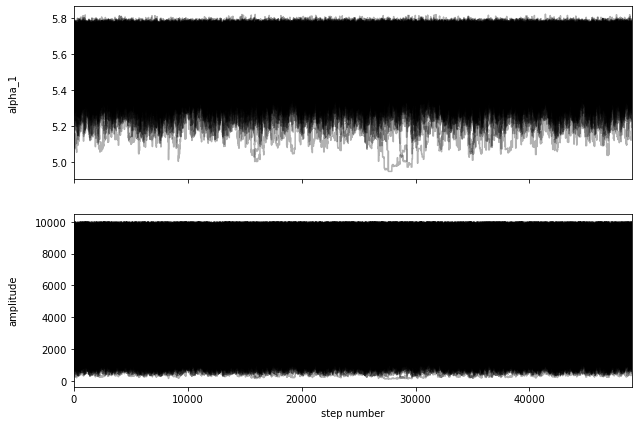

In [78]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = res_refined.chain
labels=res_refined.var_names
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [97]:
df = pd.read_csv("grb_bpl.csv")
pd_row = res_refined.params.valuesdict()
pd_row["GRB Name"] = GRBs[i]
pd_row["GRB Index"] = i
df.iloc[i] = pd_row
df.to_csv("grb_bpl.csv",index=False)

df2 = pd.read_csv("grb_initial_pl.csv")
pd_row2 = res_refined_ini.params.valuesdict()
pd_row2["GRB Name"] = GRBs[i]
pd_row2["GRB Index"] = i
df2.iloc[i] = pd_row2
df2.to_csv("grb_initial_pl.csv",index=False)

NameError: name 'res_refined_ini' is not defined

### nbroken law

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 45
    # data points      = 100
    # variables        = 4
    chi-square         = 46.2986664
    reduced chi-square = 0.48227777
    Akaike info crit   = -69.0057029
    Bayesian info crit = -58.5850222
[[Variables]]
    tb0:        214.818467 +/- 4.75079445 (2.21%) (init = 200)
    alpha_0:    1.78855299 +/- 0.06448918 (3.61%) (init = 2)
    alpha_1:    7.22522560 +/- 0.37320146 (5.17%) (init = 4.2)
    amplitude:  9.5167e-10 +/- 7.4184e-11 (7.80%) (init = 1e-09)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb0, amplitude)     = -0.7978
    C(alpha_0, amplitude) = -0.7951
    C(tb0, alpha_1)       = +0.5465
    C(tb0, alpha_0)       = +0.3879
    C(alpha_1, amplitude) = -0.2773


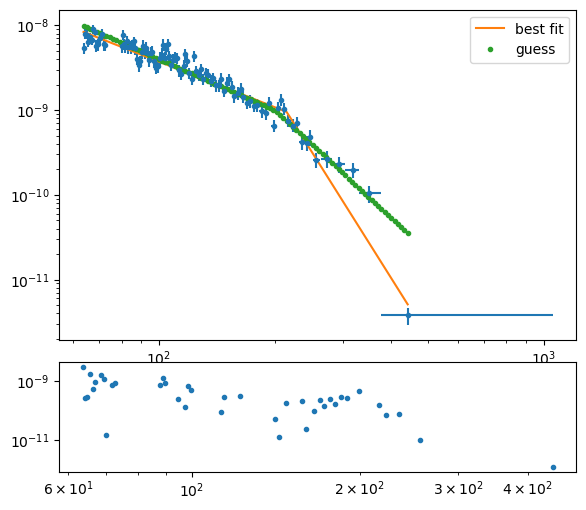

name,value,standard error,relative error,initial value,min,max,vary
tb0,214.818467,4.75079445,(2.21%),200.0,50.0000000,1000.00000,True
alpha_0,1.78855299,0.06448918,(3.61%),2,0.00000000,5.00000000,True
alpha_1,7.22522560,0.37320146,(5.17%),4.2,0.00000000,10.0000000,True
amplitude,9.5167e-10,7.4184e-11,(7.80%),1e-09,1.0000e-10,1.0000e-08,True


In [20]:
i=5
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=2
params=lm.Parameters()
params.add("tb0", min = 5e1, max = 1e3, value = 2e2)
params.add("alpha_0", min = 0, max = 5.0, value = 2)
params.add("alpha_1", min = 0, max = 10.0, value = 4.2)
params.add("amplitude", min = 1e-10, max = 1e-8, value = 1e-9)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
ax1.loglog(x, nbroken_law(x, [2e2], [2.0, 4.2], 1e-9),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.1)
plt.show()

result.params